In [8]:
import numpy                as np
import matplotlib.pyplot    as plt
from astropy import units   as units
import datetime as dt
import sys
from pathlib            import Path
from matplotlib         import rcParams, rc
from scipy.interpolate  import interp1d
import types
# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
from src.read               import read_data_chemtorch
# from src.rates          import *
from src.solve_n_save       import solve_dg
from src.input              import density
from src.datagen                import genSamples, next_input, get_dt

rate = 16

outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'
samploc = '/lhome/silkem/ChemTorch/ChemTorch/sampling/'
dataloc = '/lhome/silkem/ChemTorch/PhantomSampling/'

ImportError: cannot import name 'get_dt' from 'src.datagen' (/lhome/silkem/ChemTorch/ChemTorch/src/datagen.py)

## Getting sampling functions from Phantom distributions

In [23]:
def get_dist(nbins,file):
    data = np.loadtxt(dataloc+file+'.txt')
    out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)
    plt.title(file)
    plt.plot(out[1][:-1],out[0])
    # plt.xlim(-0.002, 0.0005)
    plt.show()
    return out


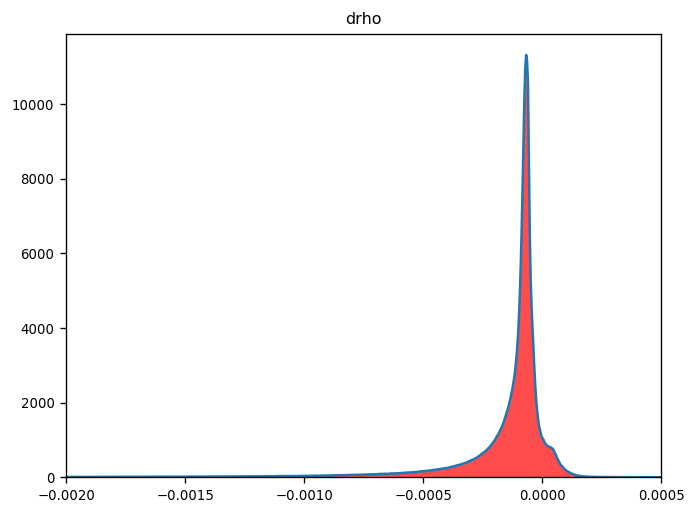

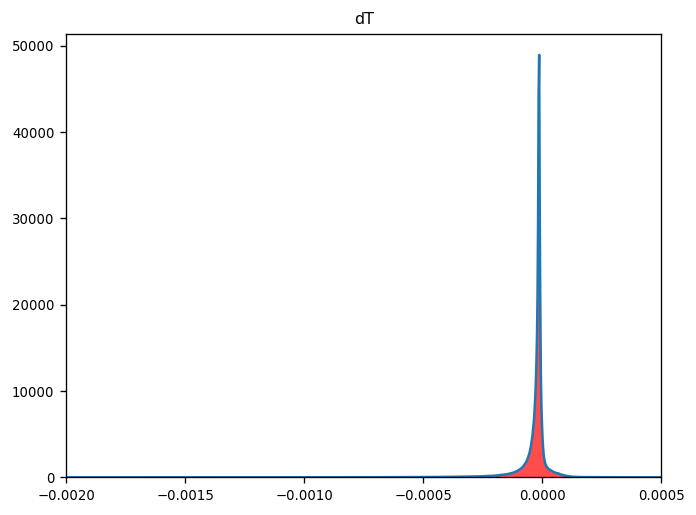

In [7]:
## diif density & temperature distributions

nbins = 100000
file = 'drho'
out_rho = get_dist(nbins, file)
file = 'dT'
out_temp = get_dist(nbins, file)


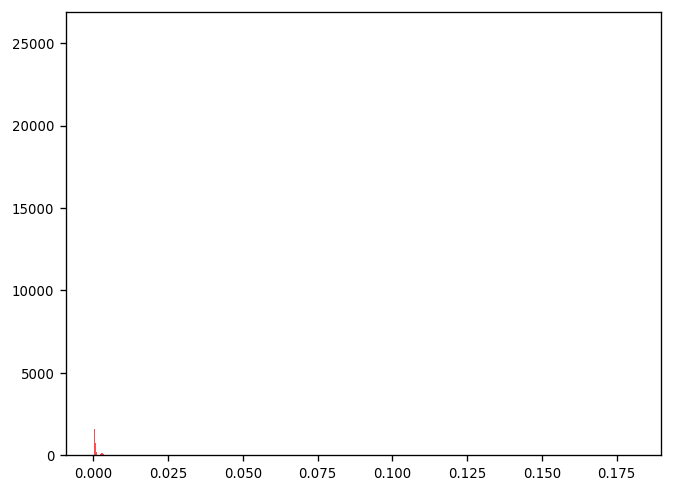

In [24]:
## dt distributions

nbins = 100000
dt1 = np.loadtxt(dataloc+'dtime1'+'.txt')
dt2 = np.loadtxt(dataloc+'dtime2'+'.txt')
dt3 = np.loadtxt(dataloc+'dtime3'+'.txt')
data = np.concatenate((dt1,dt2,dt3), axis = 0)  

# print(data.shape)

out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)


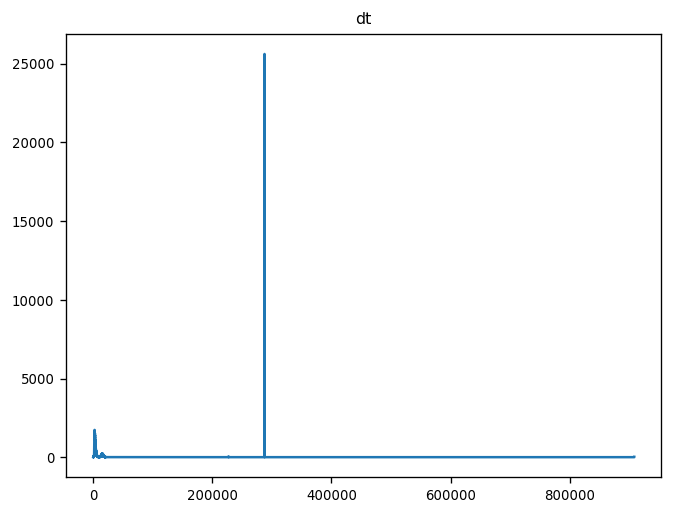

In [26]:
plt.title('dt')
plt.plot((out[1][:-1]*5022728.790082334),out[0])  ## because in PHANTOM code units ---> [sec]
# plt.xlim(-0.002, 0.075)
# plt.xscale('log')
plt.show()

In [27]:
np.save(samploc+'dtime', out[0])
np.save(samploc+'dtime_range', (out[1][:-1]*5022728.790082334)) 

In [11]:
np.save(samploc+'drho', out_rho[0]) 
np.save(samploc+'dT', out_temp[0]) 

In [16]:
np.save(samploc+'drho_range', out_rho[1][:-1]) 
np.save(samploc+'dT_range', out_temp[1][:-1]) 

## Data generation


In [8]:
# elke run eigen map, uniek, date ofzo
# checken op andere computer dat wanneer ge random seeds maakt, dat de random getallen effectief anders zijn
# nu enkel variaties van variabelen, begin met een gekozen input
# starten van de chemie waar ge mee eindigd --> paden in de fysiochemische ruimte
# eind abundantie terug meegeven, niet initialiseren

In [9]:
import src.rates        as rates

chemtype = 'C'

## set initial conditions
n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

ρi  = 1.13E+05
Ti  = 2500
δi  = 1.e-1
Avi = -np.log(1.e-3)
input = [ρi,Ti,δi,Avi]

Δt =  genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec

nf = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
    

------------------------------------------------------------------------------
Name:
2023-08-07 04:51:22.823864

Input:
[density, temperature, delta, Av] dt:
[113000.0, 2500, 0.1, 6.907755278982137] 3426.12

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 3426.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 3.91 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-07 04:51:22.823864/
------------------------------------------------------------------------------


In [8]:
nf.shape

(466,)

In [6]:
input2 = next_input(input)
Δt =  genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec
nf2 = solve_dg(input2, Δt, rate, nf, nshield_i, nconsv_tot)

------------------------------------------------------------------------------
Name:
2023-08-07 03:02:26.609593

Input:
[density, temperature, delta, Av] dt:
[108708.12382570404, 2499.958409059154, 0.13435160756113276, 5.48212857761403] 5827.61

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 5828.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 4.23 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-07 03:02:26.609593/
------------------------------------------------------------------------------


[1.13000000e+05 2.50000000e+03 1.00000000e-01 6.90775528e+00
 2.87649267e+05]
[10.24108315  0.02668953]


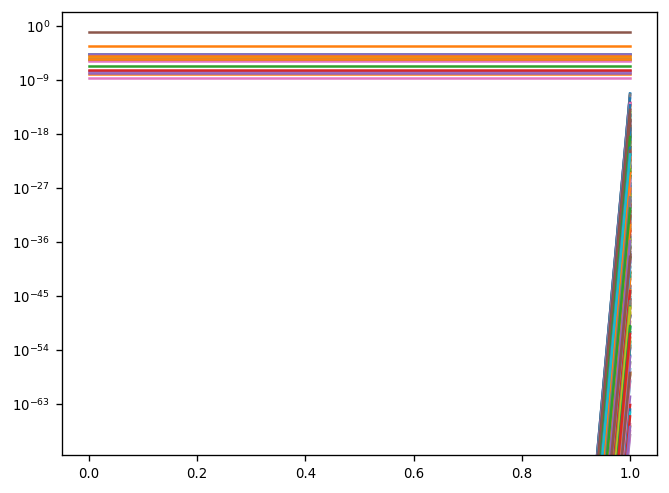

In [13]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/2023-08-07 02:06:29.447361/'

print(np.load(path+'input.npy'))
print(np.load(path+'tictoc.npy'))
# print(np.load(path+'abundances.npy'))
abs = np.load(path+'abundances.npy')

for i in range(abs.shape[0]):
    plt.plot(abs[i])

plt.yscale('log')

[1.12991248e+05 2.49995758e+03 1.07772522e-01 6.68996590e+00
 3.31475684e+03]
[4.52431154 0.03531456]
[[4.83069094e-12 4.90259564e-12]
 [4.15970822e-14 4.20753257e-14]
 [5.59389992e-16 5.65818910e-16]
 [5.04561226e-14 5.04574021e-14]
 [1.64643728e-12 1.66567989e-12]
 [8.50000000e-02 8.50000000e-02]
 [1.56834285e-13 1.58617418e-13]
 [7.43441725e-16 7.43444365e-16]
 [1.83428160e-28 1.89760425e-28]
 [1.52525380e-15 1.55896985e-15]
 [3.63082152e-12 3.67057563e-12]
 [4.93123647e-30 5.15259834e-30]
 [2.34396008e-17 2.39241222e-17]
 [6.82425441e-14 6.92245371e-14]
 [1.67254684e-17 1.70815848e-17]
 [6.30150069e-18 6.37807772e-18]
 [1.28165689e-13 1.31433247e-13]
 [7.48646171e-15 7.57282853e-15]
 [3.72538714e-15 3.86290406e-15]
 [1.34178352e-16 1.36565957e-16]
 [3.87065912e-18 3.91986869e-18]
 [1.61700586e-16 1.66907204e-16]
 [1.33046173e-19 1.34616654e-19]
 [1.38224160e-17 1.40524289e-17]
 [4.58990319e-18 4.64990627e-18]
 [2.19156061e-29 2.24133993e-29]
 [1.44663881e-16 1.46310737e-16]
 [3.037

(1e-15, 1.0)

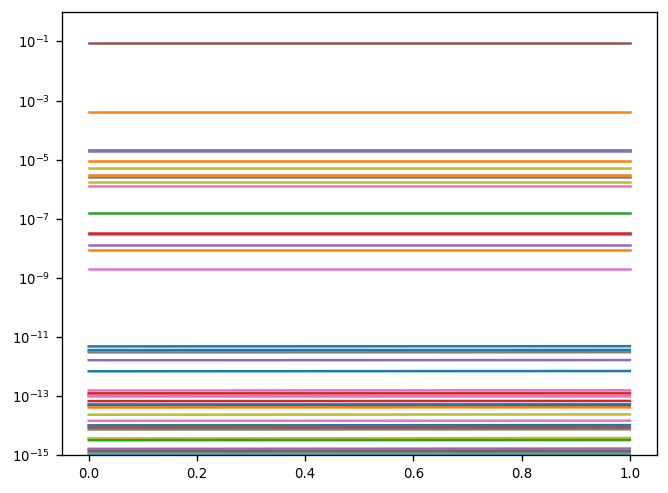

In [18]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/2023-08-07 02:13:11.924681/'

print(np.load(path+'input.npy'))
print(np.load(path+'tictoc.npy'))
print(np.load(path+'abundances.npy'))
abs = np.load(path+'abundances.npy')

for i in range(abs.shape[0]):
    plt.plot(abs[i])

plt.yscale('log')
plt.ylim([1e-15, 1e0])